# Analysis and forecast of Binance Coin (BNB) price

### Original data are downloaded from the Binance cryptocurrency exchange by using JavaScript. The following tables were obtained in CSV format: ATOMUSDT, BNBUSDT, BTCUSDT, DOGEUSDT, DOTUSDT, ETCUSDT, ETHUSDT, RVNUSDT, SHIBUSDT, SOLUSDT, XRPUSDT. 

## Importing libraries and functions.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import LinearSVR
from lightgbm import LGBMRegressor
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [49]:
# Reading data
def ReadingData(data):
    df = pd.read_csv(data, usecols = [0,1,2,3,4,5], names = ['Date', 'Open', 'High', 'Low', 'Close', 'VolumePieces'])
    df["Date"] = pd.to_datetime(df["Date"], utc=True, unit='ms')
    df['Price'] = (df['Open'] + df['Close'])/2
    df['Volume'] = df['VolumePieces'] * df['Price']
    df.drop(['Open', 'Close', 'High', 'Low', 'VolumePieces'], axis = 1, inplace = True)
    df.rename(columns = {'Price':'Price' + data[:-8], 'Volume':'Volume' + data[:-8]}, inplace = True)
    return df

# The function will print the score and MSE of our models on the training and test sets.
def ComputeMSE(model, X, y_true, name):
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    print(f'Mean Squared Error for {name}: {mse}')

def BuildEvaluate(X_train, y_train, X_test, y_test):
    def EvaluateModel(model):
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)

        print("Train Score:", train_score)
        print("Test Score:", test_score)
        print()
        
        ComputeMSE(model, X_train, y_train, 'training set')
        ComputeMSE(model, X_test, y_test, 'test set')
    return EvaluateModel

## Importing data to dataframes

In [50]:
ATOMUSDT, BNBUSDT, BTCUSDT, DOGEUSDT, DOTUSDT, ETCUSDT, ETHUSDT, RVNUSDT, SHIBUSDT, SOLUSDT, XRPUSDT = [ReadingData(data) for data in ['ATOMUSDT.csv', 'BNBUSDT.csv', 'BTCUSDT.csv', 'DOGEUSDT.csv', 'DOTUSDT.csv', 'ETCUSDT.csv', 'ETHUSDT.csv', 'RVNUSDT.csv', 'SHIBUSDT.csv', 'SOLUSDT.csv', 'XRPUSDT.csv']]
df = ATOMUSDT.merge(BNBUSDT, on = 'Date').merge(BTCUSDT, on = 'Date').merge(DOGEUSDT, on = 'Date').merge(DOTUSDT, on = 'Date').merge(ETCUSDT, on = 'Date').merge(ETHUSDT, on = 'Date').merge(RVNUSDT, on = 'Date').merge(SHIBUSDT, on = 'Date').merge(SOLUSDT, on = 'Date').merge(XRPUSDT, on = 'Date')
df.set_index('Date', inplace = True)
df.dropna()
df

,PriceATOM,VolumeATOM,PriceBNB,VolumeBNB,PriceBTC,VolumeBTC,PriceDOGE,VolumeDOGE,PriceDOT,VolumeDOT,...,PriceETH,VolumeETH,PriceRVN,VolumeRVN,PriceSHIB,VolumeSHIB,PriceSOL,VolumeSOL,PriceXRP,VolumeXRP
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-10 11:00:00+00:00,27.7465,93146.471064,662.375,1.820122e+06,57799.690,2.492596e+06,0.500875,6.708833e+06,39.6810,587453.436081,...,4033.390,4.087053e+06,0.16468,9953.588560,0.000024,2.476790e+07,44.2070,108557.361620,1.56385,9.709250e+05
2021-05-10 11:01:00+00:00,27.6135,107102.577119,660.465,1.104051e+06,57690.835,2.546106e+06,0.496360,7.595519e+06,39.5595,625243.514949,...,4023.345,6.007924e+06,0.16425,34739.236350,0.000033,1.577004e+07,44.1820,85109.774790,1.55790,1.167212e+06
2021-05-10 11:02:00+00:00,27.5875,86514.096537,659.985,1.739739e+06,57643.875,3.509157e+06,0.495120,1.104101e+07,39.4905,304691.401161,...,4015.380,8.383786e+06,0.16387,27090.660660,0.000031,1.037899e+07,44.1970,195625.291764,1.55515,1.029316e+06
2021-05-10 11:03:00+00:00,27.6075,83194.897568,660.610,1.073787e+06,57686.190,2.949968e+06,0.495705,4.860208e+06,39.4775,423030.507417,...,4021.845,6.756758e+06,0.16413,18957.047826,0.000030,9.630709e+06,44.2335,93770.065848,1.55600,1.083671e+06
2021-05-10 11:04:00+00:00,27.5970,86670.586260,660.945,8.918993e+05,57689.230,2.689412e+06,0.497950,6.710085e+06,39.4595,250321.952855,...,4024.360,5.407790e+06,0.16410,22793.046930,0.000029,7.110857e+06,44.2075,50718.999505,1.55560,1.310971e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-08 23:55:00+00:00,12.1350,52142.760150,326.850,3.700746e+05,18508.180,7.083663e+06,0.087895,3.709102e+05,6.2750,26524.174000,...,1330.865,6.451654e+05,0.02521,10661.240933,0.000010,5.155819e+04,24.2300,443434.926100,0.40485,1.395595e+05
2022-11-08 23:56:00+00:00,12.1500,54806.220000,327.700,2.841467e+05,18523.445,5.689614e+06,0.088105,3.134048e+05,6.2850,27937.327800,...,1332.205,4.199616e+05,0.02522,6716.373508,0.000010,3.301806e+04,24.3050,296554.540900,0.40535,2.020074e+05
2022-11-08 23:57:00+00:00,12.1555,32600.686335,328.150,1.915284e+05,18535.485,3.079102e+06,0.088370,2.272390e+05,6.3000,6286.140000,...,1333.510,6.912173e+05,0.02528,2273.875328,0.000010,2.216659e+04,24.3100,137844.749900,0.40600,1.154806e+05


In [51]:
df.columns

Index(['PriceATOM', 'VolumeATOM', 'PriceBNB', 'VolumeBNB', 'PriceBTC',
       'VolumeBTC', 'PriceDOGE', 'VolumeDOGE', 'PriceDOT', 'VolumeDOT',
       'PriceETC', 'VolumeETC', 'PriceETH', 'VolumeETH', 'PriceRVN',
       'VolumeRVN', 'PriceSHIB', 'VolumeSHIB', 'PriceSOL', 'VolumeSOL',
       'PriceXRP', 'VolumeXRP'],
      dtype='object')

### Description of the data set


Sign | Description
-------------------|--------------------
Date       | Date and time
Volume       | Volume of transactions performed with defined cryptoassets in USDT
Price       | Average price of defined cryptoassets in USDT
ATOM, BNB, BTC, BUSD, DOGE, DOT, ETC, ETH, RVN, SHIB, SOL, XRP      | Сryptoassets 

### Basic statistics

In [52]:
df.describe()

,PriceATOM,VolumeATOM,PriceBNB,VolumeBNB,PriceBTC,VolumeBTC,PriceDOGE,VolumeDOGE,PriceDOT,VolumeDOT,...,PriceETH,VolumeETH,PriceRVN,VolumeRVN,PriceSHIB,VolumeSHIB,PriceSOL,VolumeSOL,PriceXRP,VolumeXRP
count,788062.000000,7.880620e+05,788062.000000,7.880620e+05,788062.000000,7.880620e+05,788062.000000,7.880620e+05,788062.000000,7.880620e+05,...,788062.000000,7.880620e+05,788062.000000,7.880620e+05,788062.000000,7.880620e+05,788062.000000,7.880620e+05,788062.000000,7.880620e+05
mean,20.486465,6.421343e+04,379.375105,3.156811e+05,37237.830481,2.101964e+06,0.167278,2.460389e+05,19.614983,1.681591e+05,...,2620.045311,1.193538e+06,0.068537,1.023805e+04,0.000019,2.542917e+05,86.798311,2.284960e+05,0.720201,2.442449e+05
std,9.967265,1.398991e+05,104.955341,5.754771e+05,12705.784652,2.871200e+06,0.094359,7.471758e+05,11.579694,3.614306e+05,...,982.384724,1.830314e+06,0.036439,3.156598e+04,0.000013,9.141603e+05,61.836530,4.613091e+05,0.291779,4.795653e+05
min,5.565000,0.000000e+00,184.300000,3.264396e+02,17265.555000,1.122059e+04,0.049355,0.000000e+00,5.710000,0.000000e+00,...,887.490000,4.418440e+03,0.017195,0.000000e+00,0.000005,0.000000e+00,19.340500,0.000000e+00,0.288650,7.790580e+01
25%,11.732500,1.055330e+04,294.350000,6.629749e+04,23654.017500,6.670687e+05,0.078000,2.071711e+04,8.430000,2.301185e+04,...,1720.301250,3.605491e+05,0.035655,1.058100e+03,0.000009,2.232685e+04,34.620000,4.494659e+04,0.444000,5.220265e+04
50%,16.373500,2.561804e+04,368.000000,1.543374e+05,38540.570000,1.256000e+06,0.146050,6.399740e+04,18.195000,6.776031e+04,...,2625.225000,6.676075e+05,0.059620,3.097767e+03,0.000012,5.855783e+04,52.670000,1.037917e+05,0.733650,1.133432e+05
75%,28.695000,6.298958e+04,434.450000,3.401067e+05,46292.490000,2.463446e+06,0.234650,1.916231e+05,26.860000,1.748425e+05,...,3299.741250,1.294532e+06,0.097865,8.474090e+03,0.000026,1.693214e+05,135.950000,2.380312e+05,0.927000,2.517254e+05
max,44.615000,9.094408e+06,684.000000,5.502153e+07,68900.000000,1.168330e+08,0.589495,5.184341e+07,55.010000,2.751151e+07,...,4861.700000,6.468658e+07,0.177140,2.791642e+06,0.000088,7.141733e+07,259.735000,3.070826e+07,1.697800,2.670559e+07


### Consider graphs of volume and price vs. time

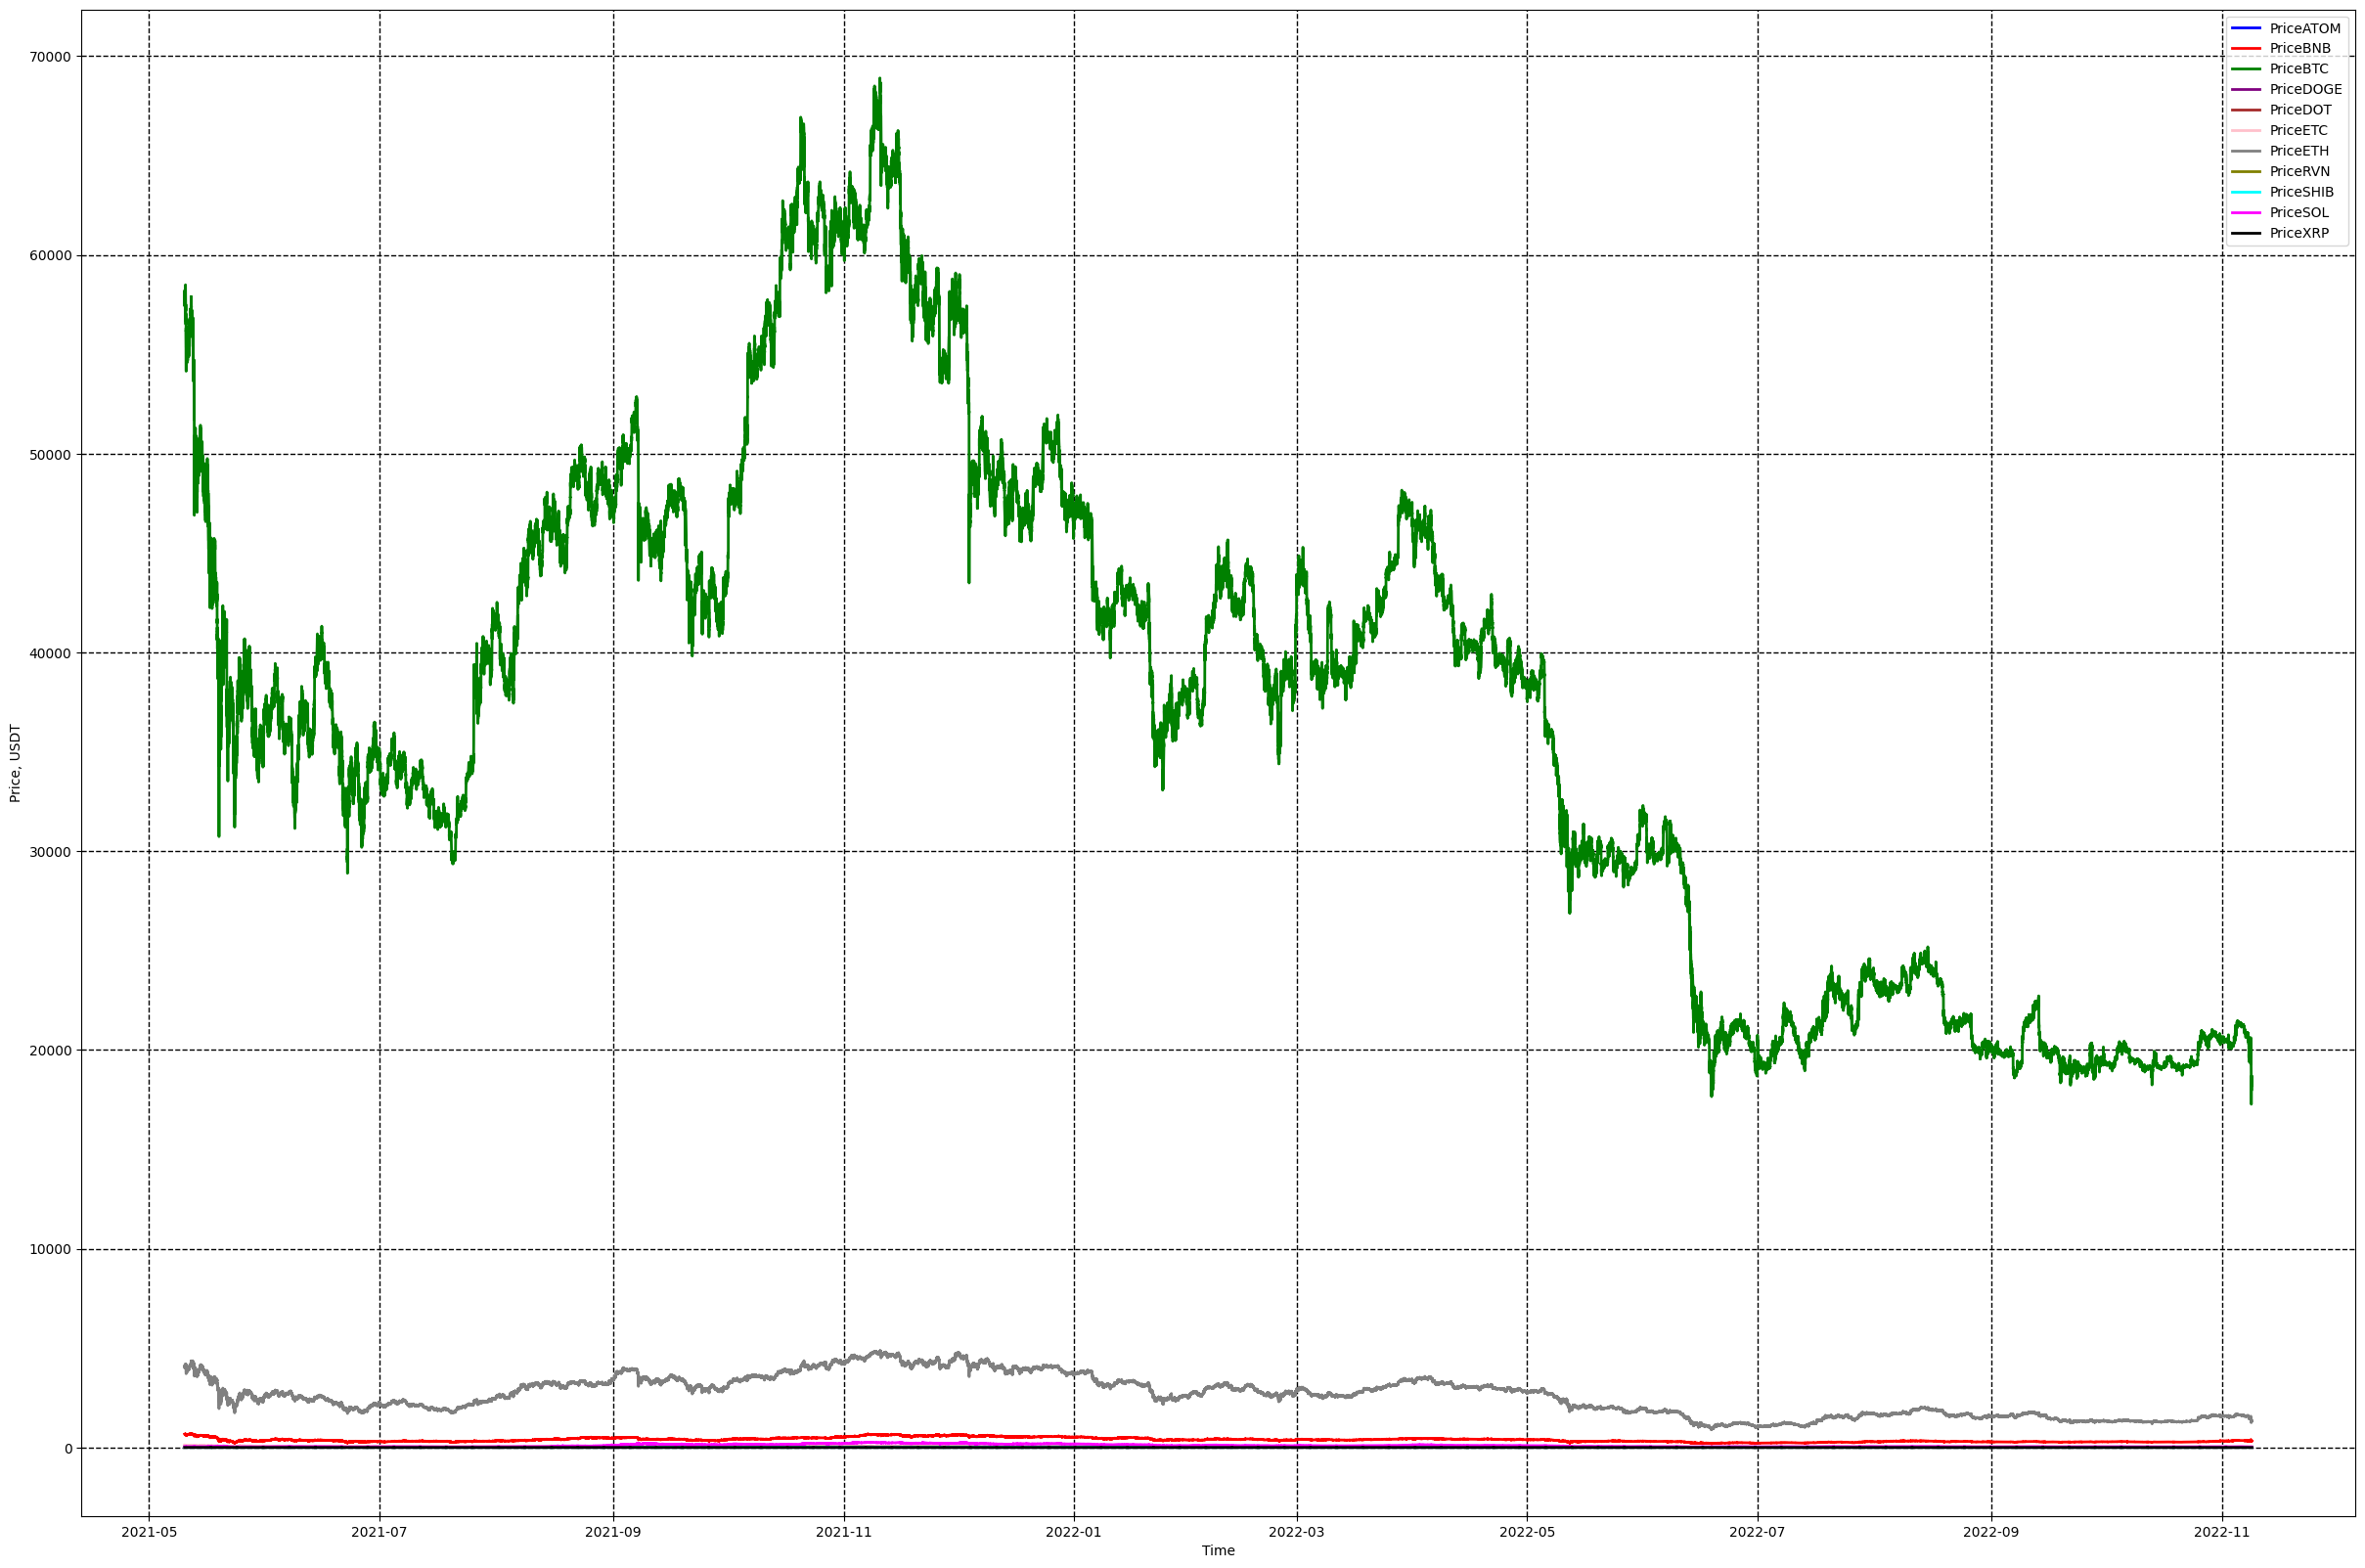

In [53]:
plt.figure(figsize=(30, 20))
plt.plot('PriceATOM', data=df, marker='', color='blue', linewidth=2)
plt.plot('PriceBNB', data=df, marker='', color='red', linewidth=2)
plt.plot('PriceBTC', data=df, marker='', color='green', linewidth=2)
plt.plot('PriceDOGE', data=df, marker='', color='purple', linewidth=2)
plt.plot('PriceDOT', data=df, marker='', color='brown', linewidth=2)
plt.plot('PriceETC', data=df, marker='', color='pink', linewidth=2)
plt.plot('PriceETH', data=df, marker='', color='gray', linewidth=2)
plt.plot('PriceRVN', data=df, marker='', color='olive', linewidth=2)
plt.plot('PriceSHIB', data=df, marker='', color='cyan', linewidth=2)
plt.plot('PriceSOL', data=df, marker='', color='magenta', linewidth=2)
plt.plot('PriceXRP', data=df, marker='', color='black', linewidth=2)
plt.grid(color = 'black', linewidth = 1, linestyle = '--') 
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price, USDT')
plt.show()

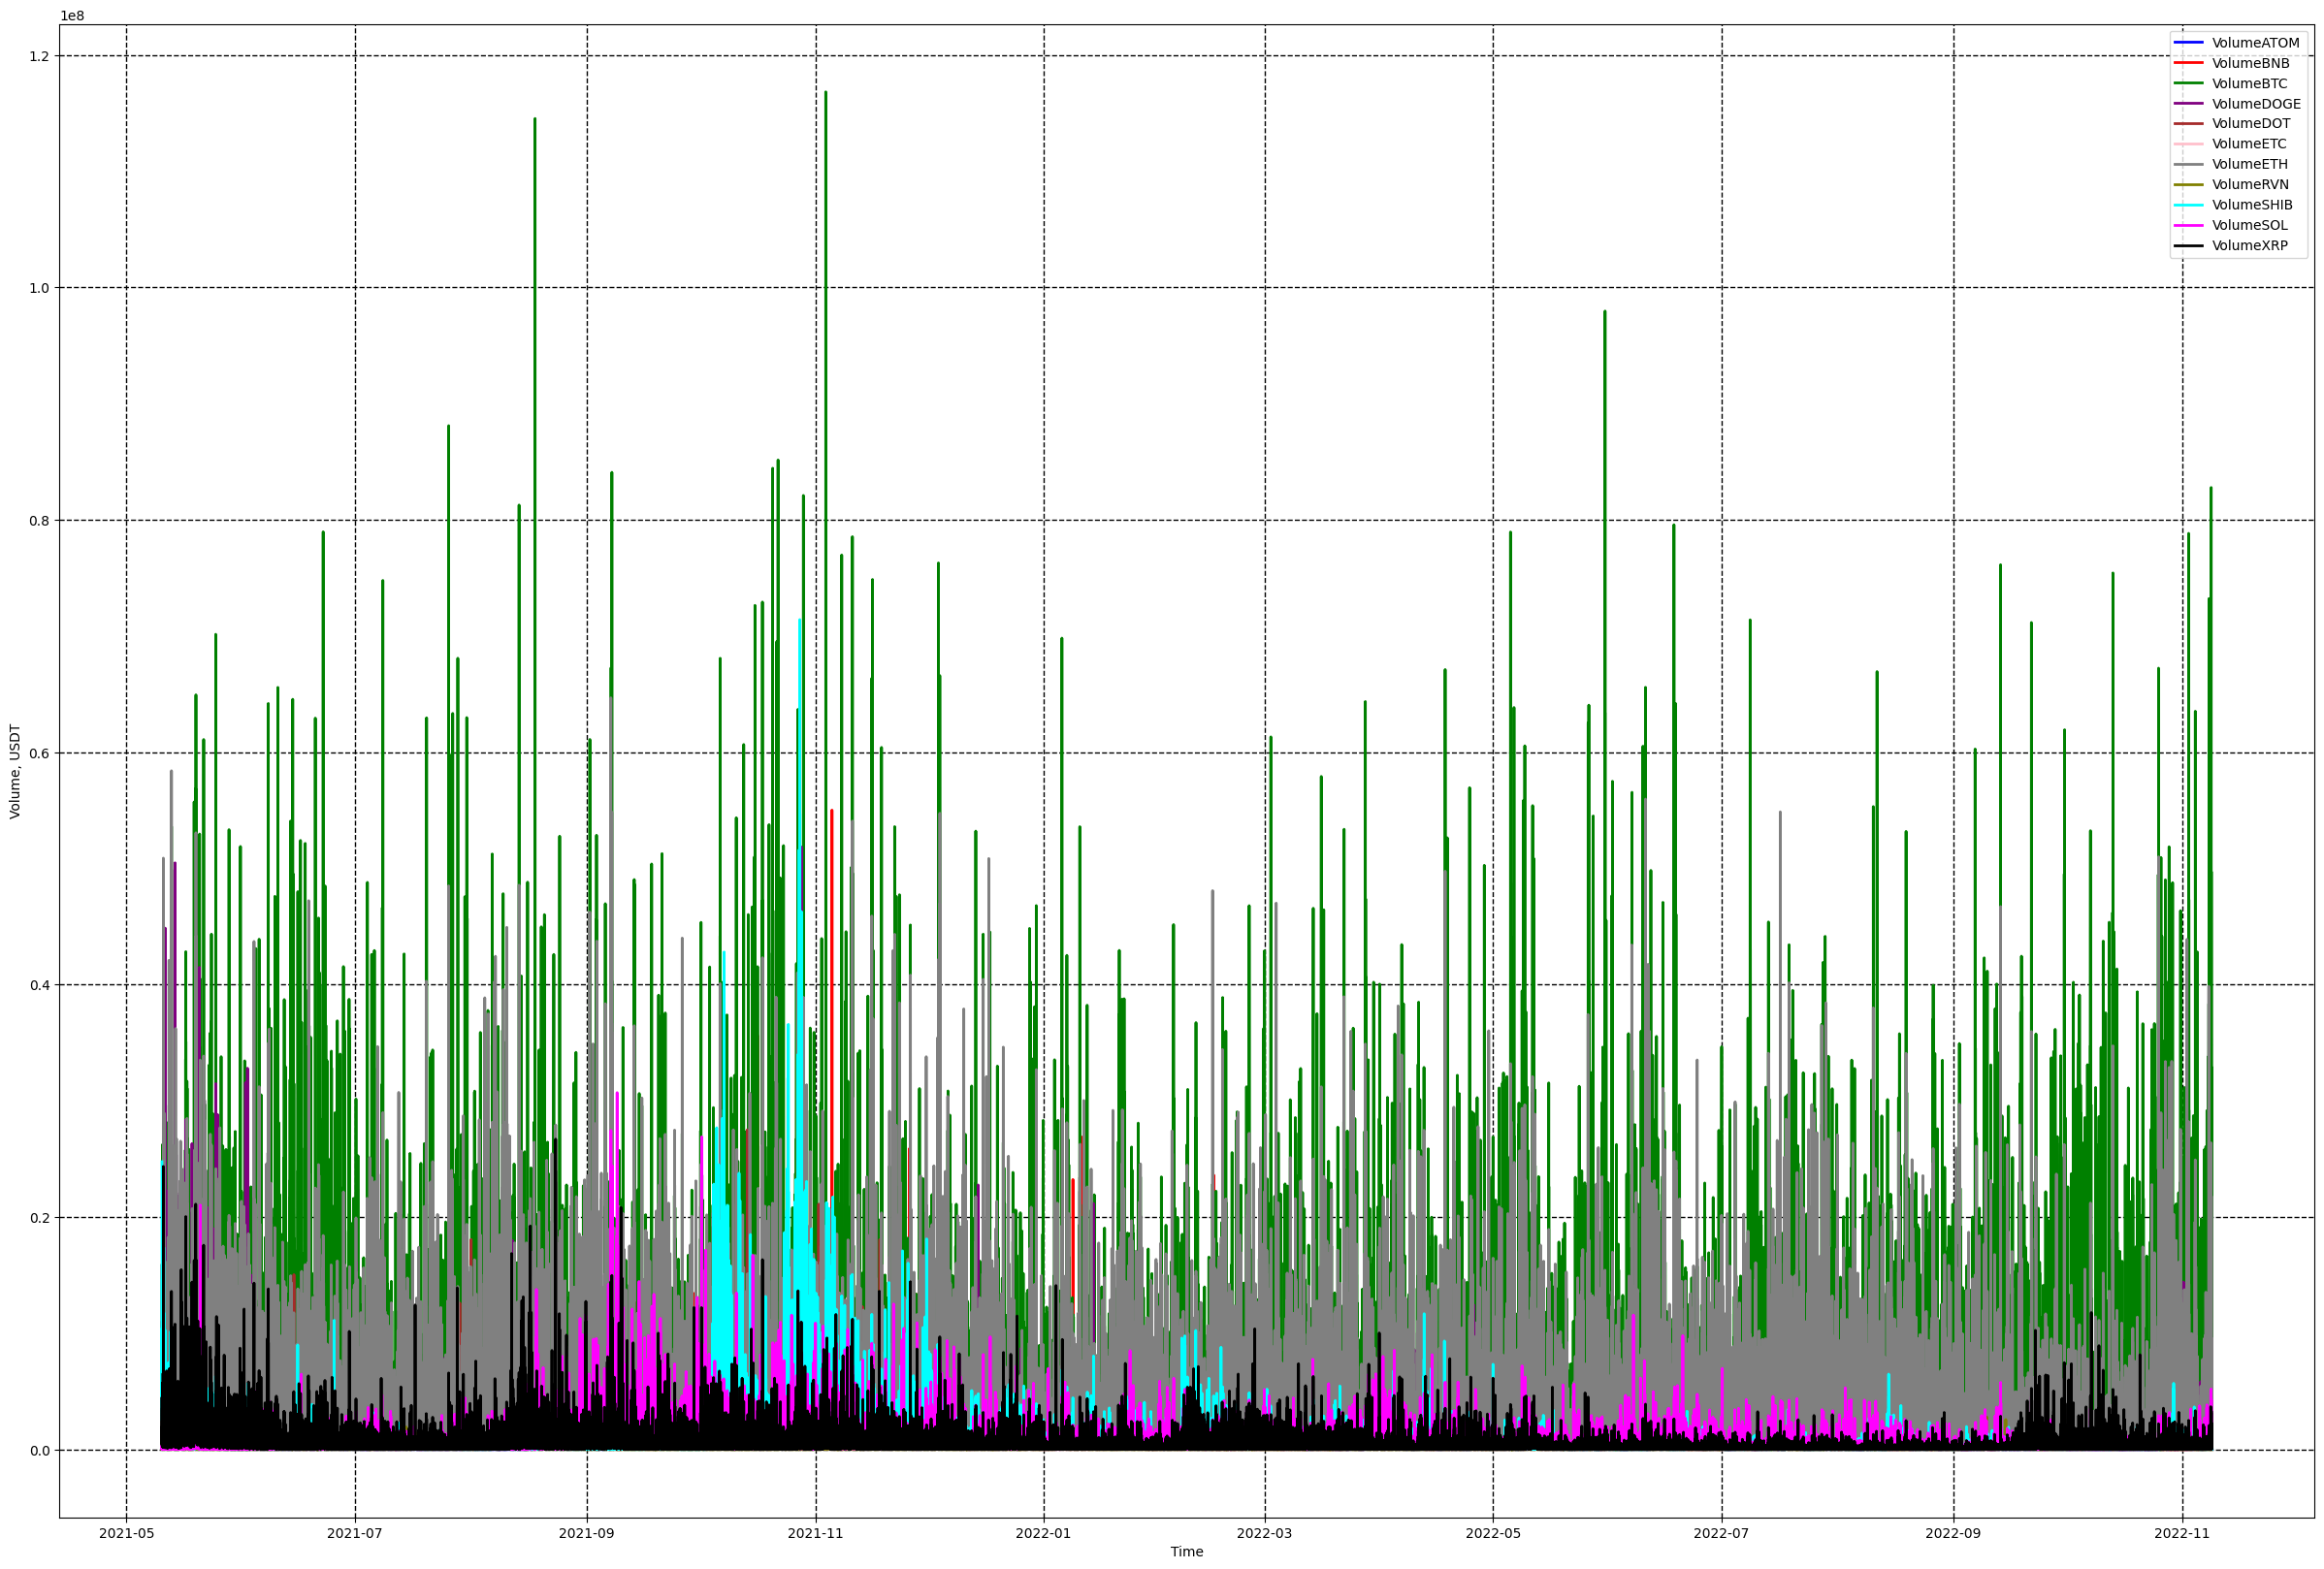

In [54]:
plt.figure(figsize=(30, 20))
plt.plot('VolumeATOM', data=df, marker='', color='blue', linewidth=2)
plt.plot('VolumeBNB', data=df, marker='', color='red', linewidth=2)
plt.plot('VolumeBTC', data=df, marker='', color='green', linewidth=2)
plt.plot('VolumeDOGE', data=df, marker='', color='purple', linewidth=2)
plt.plot('VolumeDOT', data=df, marker='', color='brown', linewidth=2)
plt.plot('VolumeETC', data=df, marker='', color='pink', linewidth=2)
plt.plot('VolumeETH', data=df, marker='', color='gray', linewidth=2)
plt.plot('VolumeRVN', data=df, marker='', color='olive', linewidth=2)
plt.plot('VolumeSHIB', data=df, marker='', color='cyan', linewidth=2)
plt.plot('VolumeSOL', data=df, marker='', color='magenta', linewidth=2)
plt.plot('VolumeXRP', data=df, marker='', color='black', linewidth=2)
plt.grid(color = 'black', linewidth = 1, linestyle = '--') 
plt.legend()
plt.xlabel('Time')
plt.ylabel('Volume, USDT')
plt.show()

### Scaler values and prices

In [55]:
scaler = MinMaxScaler()
scaler_df = pd.DataFrame(data = scaler.fit_transform(df), index = df.index, columns = df.columns)
scaler_df.head(5)

,PriceATOM,VolumeATOM,PriceBNB,VolumeBNB,PriceBTC,VolumeBTC,PriceDOGE,VolumeDOGE,PriceDOT,VolumeDOT,...,PriceETH,VolumeETH,PriceRVN,VolumeRVN,PriceSHIB,VolumeSHIB,PriceSOL,VolumeSOL,PriceXRP,VolumeXRP
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-10 11:00:00+00:00,0.568028,0.010242,0.956724,0.033074,0.785021,0.021241,0.835931,0.129406,0.689067,0.021353,...,0.791579,0.063118,0.922098,0.003565,0.221493,0.346805,0.103440,0.003535,0.904943,0.036354
2021-05-10 11:01:00+00:00,0.564622,0.011777,0.952902,0.020060,0.782913,0.021699,0.827572,0.146509,0.686602,0.022727,...,0.789051,0.092815,0.919410,0.012444,0.330102,0.220815,0.103336,0.002772,0.900720,0.043704
2021-05-10 11:02:00+00:00,0.563956,0.009513,0.951941,0.031613,0.782004,0.029942,0.825277,0.212969,0.685203,0.011075,...,0.787047,0.129547,0.917034,0.009704,0.313185,0.145329,0.103399,0.006370,0.898769,0.038540
2021-05-10 11:03:00+00:00,0.564469,0.009148,0.953192,0.019510,0.782823,0.025156,0.826360,0.093748,0.684939,0.015376,...,0.788674,0.104393,0.918660,0.006791,0.300241,0.134851,0.103551,0.003054,0.899372,0.040576
2021-05-10 11:04:00+00:00,0.564200,0.009530,0.953862,0.016204,0.782882,0.022925,0.830516,0.129430,0.684574,0.009099,...,0.789307,0.083537,0.918472,0.008165,0.281337,0.099568,0.103442,0.001652,0.899088,0.049087


### Consider new graphs of volume and price vs. time

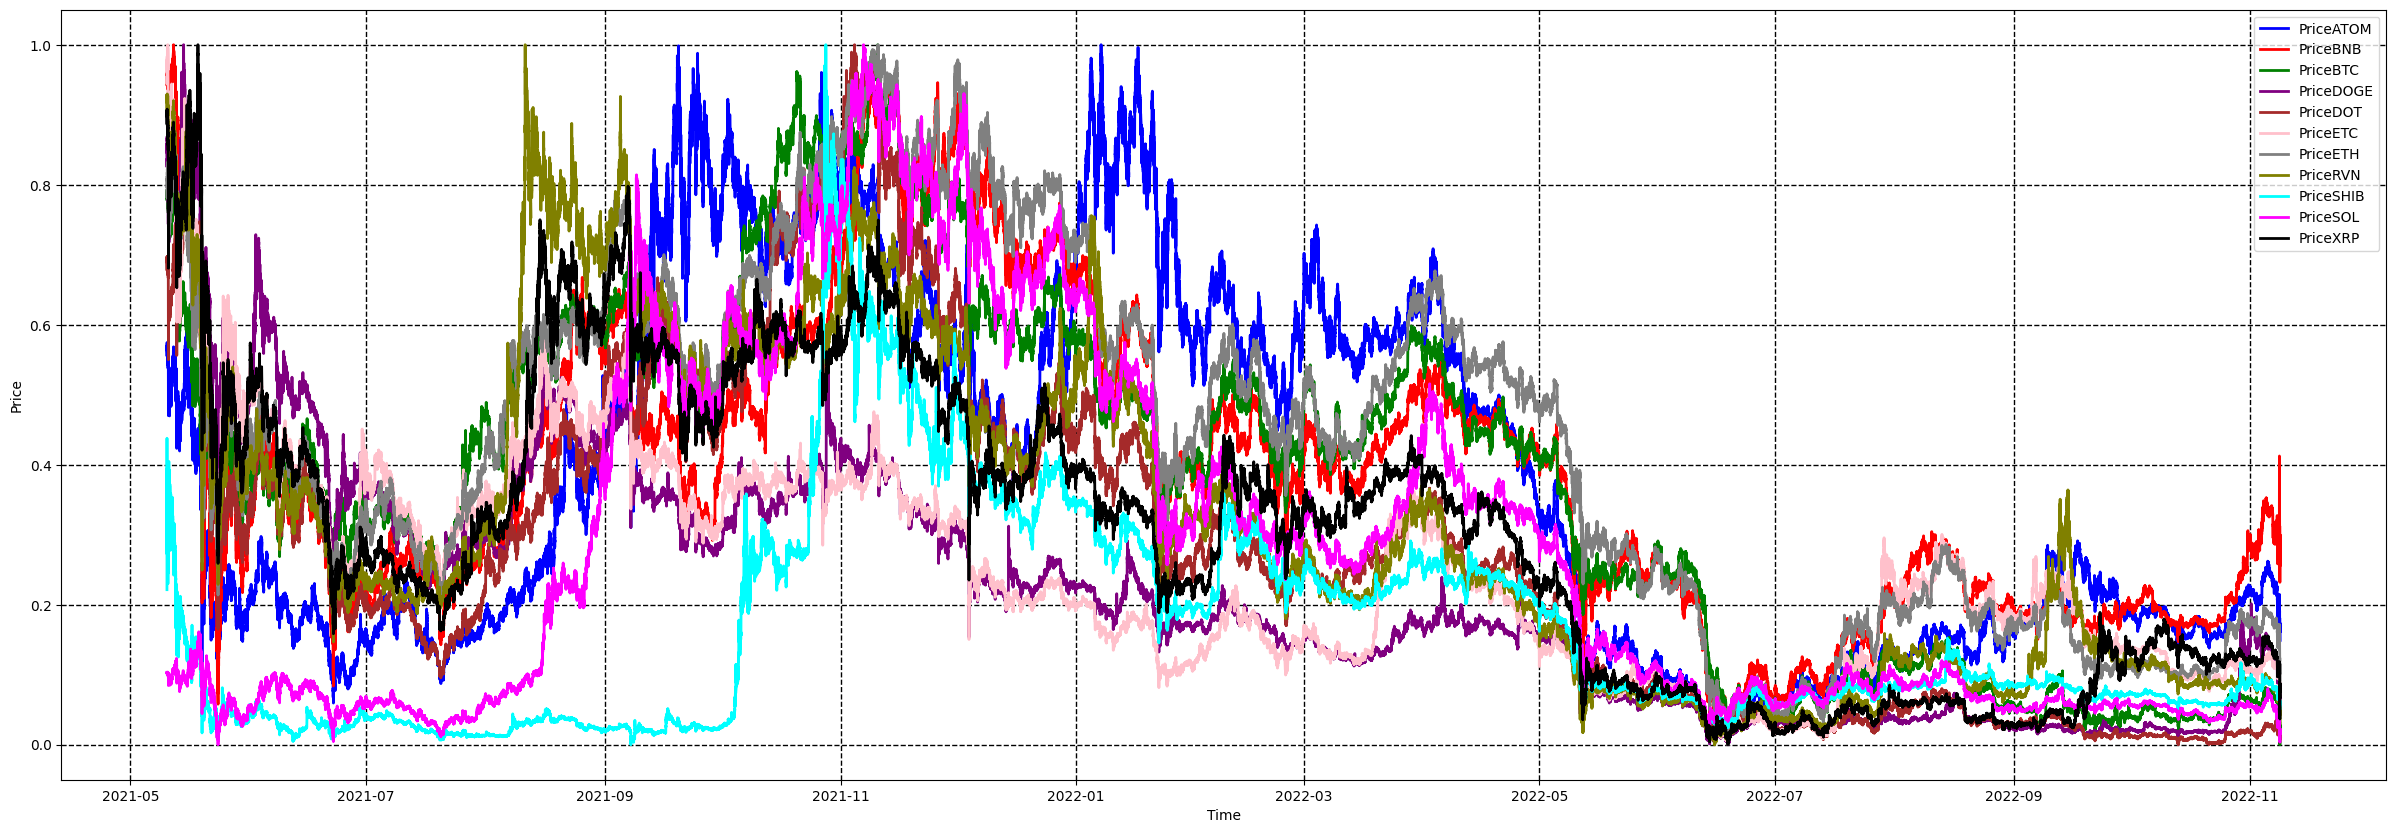

In [56]:
plt.figure(figsize=(30, 10))
plt.plot('PriceATOM', data=scaler_df, marker='', color='blue', linewidth=2)
plt.plot('PriceBNB', data=scaler_df, marker='', color='red', linewidth=2)
plt.plot('PriceBTC', data=scaler_df, marker='', color='green', linewidth=2)
plt.plot('PriceDOGE', data=scaler_df, marker='', color='purple', linewidth=2)
plt.plot('PriceDOT', data=scaler_df, marker='', color='brown', linewidth=2)
plt.plot('PriceETC', data=scaler_df, marker='', color='pink', linewidth=2)
plt.plot('PriceETH', data=scaler_df, marker='', color='gray', linewidth=2)
plt.plot('PriceRVN', data=scaler_df, marker='', color='olive', linewidth=2)
plt.plot('PriceSHIB', data=scaler_df, marker='', color='cyan', linewidth=2)
plt.plot('PriceSOL', data=scaler_df, marker='', color='magenta', linewidth=2)
plt.plot('PriceXRP', data=scaler_df, marker='', color='black', linewidth=2)
plt.grid(color = 'black', linewidth = 1, linestyle = '--') 
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

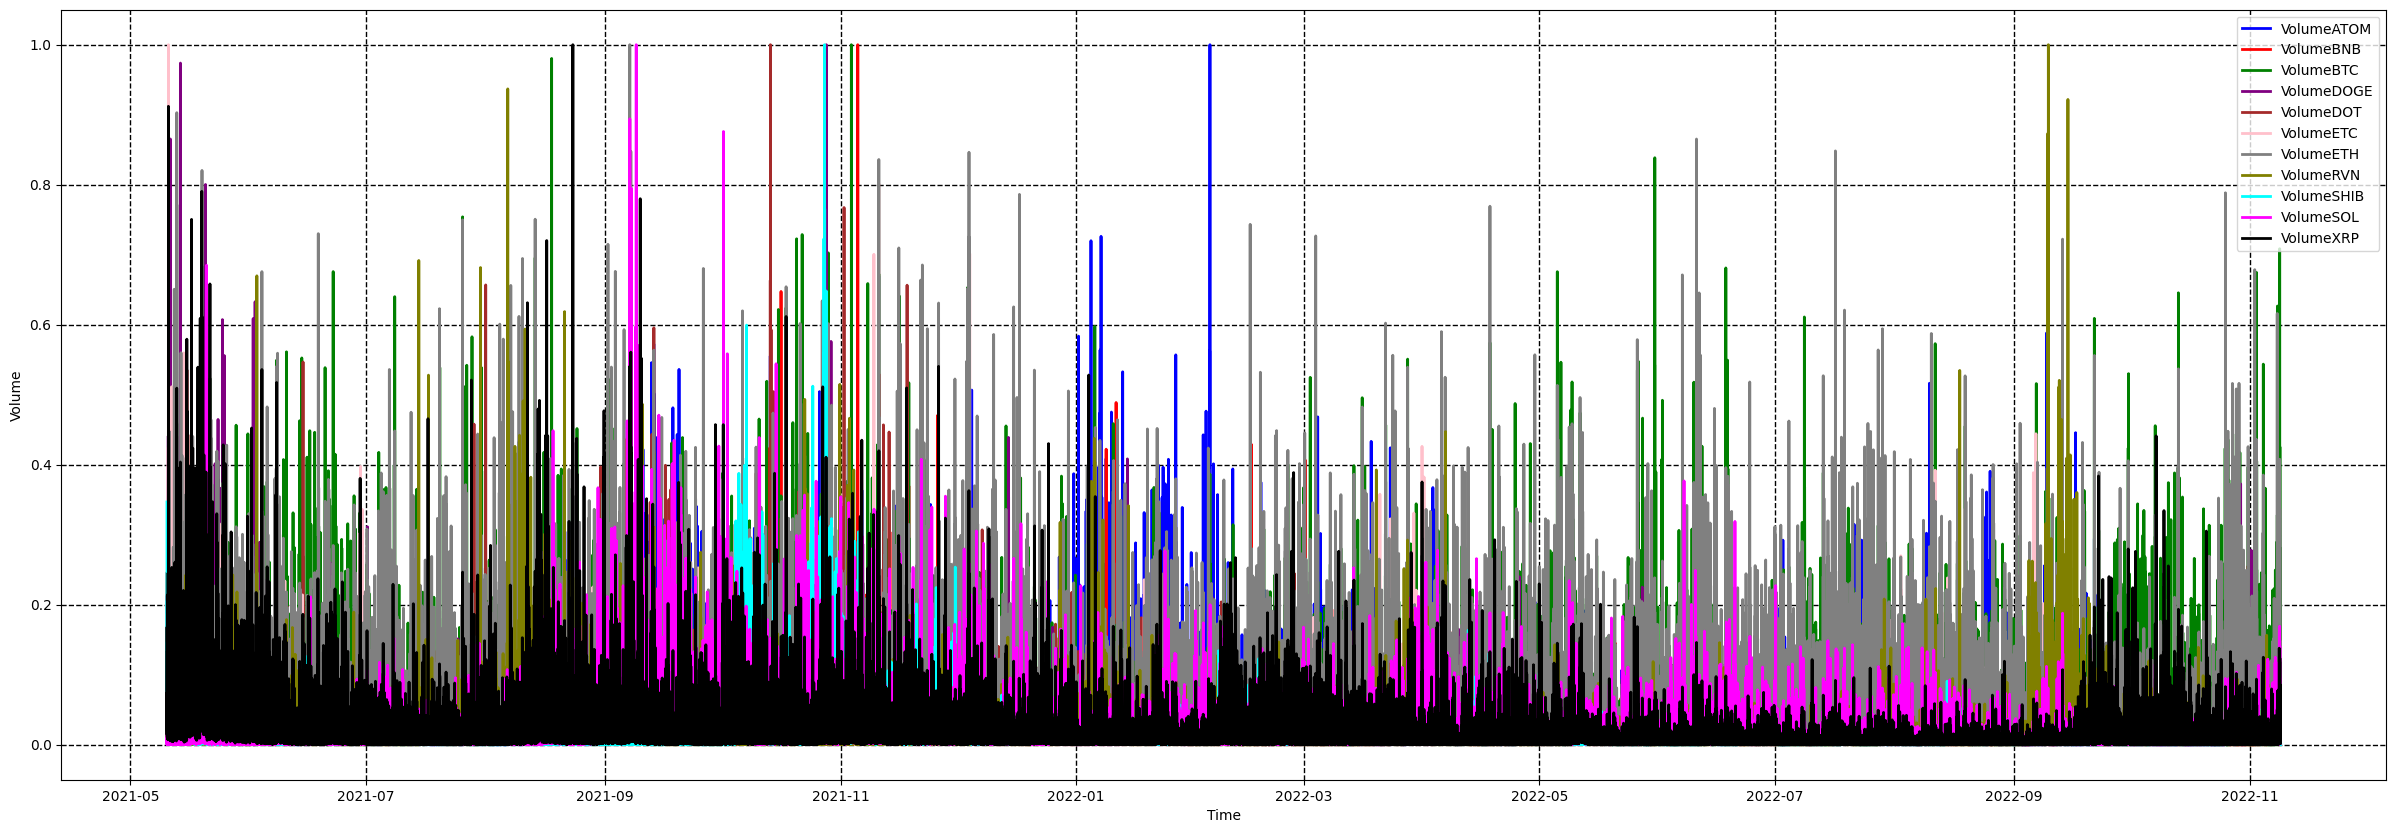

In [57]:
plt.figure(figsize=(30, 10))
plt.plot('VolumeATOM', data=scaler_df, marker='', color='blue', linewidth=2)
plt.plot('VolumeBNB', data=scaler_df, marker='', color='red', linewidth=2)
plt.plot('VolumeBTC', data=scaler_df, marker='', color='green', linewidth=2)
plt.plot('VolumeDOGE', data=scaler_df, marker='', color='purple', linewidth=2)
plt.plot('VolumeDOT', data=scaler_df, marker='', color='brown', linewidth=2)
plt.plot('VolumeETC', data=scaler_df, marker='', color='pink', linewidth=2)
plt.plot('VolumeETH', data=scaler_df, marker='', color='gray', linewidth=2)
plt.plot('VolumeRVN', data=scaler_df, marker='', color='olive', linewidth=2)
plt.plot('VolumeSHIB', data=scaler_df, marker='', color='cyan', linewidth=2)
plt.plot('VolumeSOL', data=scaler_df, marker='', color='magenta', linewidth=2)
plt.plot('VolumeXRP', data=scaler_df, marker='', color='black', linewidth=2)
plt.grid(color = 'black', linewidth = 1, linestyle = '--') 
plt.legend()
plt.xlabel('Time')
plt.ylabel('Volume')
plt.show()

## Problem statement and model building

Our task is to determine the correlation between the price of BNB and the price and volume of transactions of other cryptoassets under research.


### Split the dataset into train and test samples.

In [58]:
X=scaler_df.drop(['PriceBNB', 'VolumeBNB'], axis = 1)
y=scaler_df['PriceBNB']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
EvaluateModel = BuildEvaluate(X_train, y_train, X_test, y_test)

### Linear Regression

In [60]:
%%time
model = LinearRegression()
model.fit(X_train, y_train)

CPU times: user 1.25 s, sys: 427 ms, total: 1.67 s
Wall time: 706 ms


LinearRegression()

In [61]:
EvaluateModel(model)

Train Score: 0.9503525157798394
Test Score: 0.9503143817455413

Mean Squared Error for training set: 0.002189362254212244
Mean Squared Error for test set: 0.0021953137246827495


### SVM

In [62]:
%%time
svm = LinearSVR()
svm.fit(X_train, y_train)

CPU times: user 2min 26s, sys: 331 ms, total: 2min 27s
Wall time: 2min 26s


LinearSVR()

In [63]:
EvaluateModel(svm)

Train Score: 0.9471853136396103
Test Score: 0.9469063185413413

Mean Squared Error for training set: 0.0023290300123312326
Mean Squared Error for test set: 0.0023458958888907025


### Gradient Boosting Machine

In [64]:
%%time
gbr = LGBMRegressor(n_estimators=1000)
gbr.fit(X_train, y_train)

CPU times: user 4min 20s, sys: 831 ms, total: 4min 21s
Wall time: 24 s


LGBMRegressor(n_estimators=1000)

In [65]:
EvaluateModel(gbr)

Train Score: 0.9996651185492538
Test Score: 0.9996383925477278

Mean Squared Error for training set: 1.4767652770648901e-05
Mean Squared Error for test set: 1.5977295459123482e-05


## Output
### Graph of results comparison

In [66]:
X_test.sort_index(ascending=False)
y_test.sort_index(ascending=False)
Output = pd.DataFrame()
Output['PriceBNB'] = y_test
Output['PredictLinerModel'] = model.predict(X_test)
Output['PredictSVM'] = svm.predict(X_test)
Output['PredictGBR'] = gbr.predict(X_test)
Output

,PriceBNB,PredictLinerModel,PredictSVM,PredictGBR
Date,,,,
2021-12-08 10:03:00+00:00,0.800881,0.803080,0.789621,0.795193
2022-06-11 03:46:00+00:00,0.208825,0.154566,0.150155,0.206800
2021-12-07 06:20:00+00:00,0.808985,0.794606,0.783387,0.806199
2021-07-31 02:43:00+00:00,0.276726,0.264825,0.257275,0.280027
2022-03-18 08:01:00+00:00,0.405643,0.414057,0.403350,0.404157
...,...,...,...,...
2022-06-11 11:33:00+00:00,0.193116,0.132399,0.128733,0.187702
2021-09-20 05:15:00+00:00,0.419552,0.426052,0.413177,0.419880
2021-07-21 17:13:00+00:00,0.211977,0.214095,0.209581,0.212110


<AxesSubplot: title={'center': 'Output'}, xlabel='Date', ylabel='PriceBNB'>

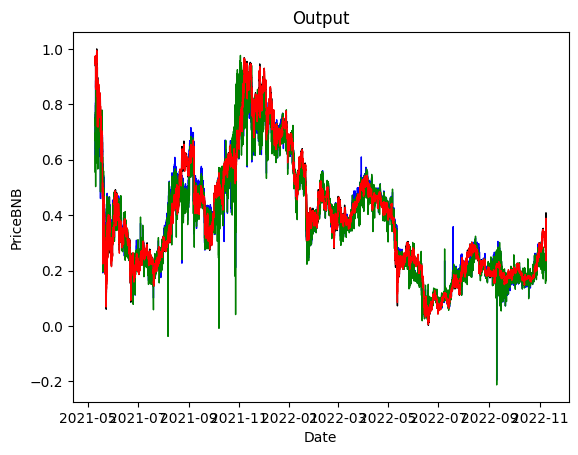

In [67]:
sns.lineplot(x='Date', y='PriceBNB', data=Output, linewidth=1, color='black').set(title='Output')
sns.lineplot(x='Date', y='PredictLinerModel', data=Output, linewidth=1, color='blue')
sns.lineplot(x='Date', y='PredictSVM', data=Output, linewidth=1, color='green')
sns.lineplot(x='Date', y='PredictGBR', data=Output, linewidth=1, color='red')

## The Gradient Boosting Machine is the most accurate way to predict the price of BNB. 
## And the study also shows a strong dependence of BNB on other crypto-assets.